# Model Formulation

This notebook can be used to run initial model with DCOPF and a basic budget variable. Before running this nodebook please refer to `Test-System-Data-Processing.ipynb` to preprocess generator, lines, buses, and loads data. 

In [1]:
using JuMP, Gurobi
using DataFrames, CSV

In [133]:
# Global path to test system datasets
PATH = joinpath(pwd(), "..", "data", "test_system") 

# Load each of the San Diego test system files 
gens = CSV.read(joinpath(PATH, "gens.csv"), DataFrame);
lines = CSV.read(joinpath(PATH, "lines.csv"), DataFrame);
buses = CSV.read(joinpath(PATH, "buses.csv"), DataFrame);
loads = CSV.read(joinpath(PATH, "loads_24h_su.csv"), DataFrame);

gens = gens[gens[:, :fueltype] .≠ "Synchronous Condenser", :]

# Add load to bus dataset equal to first hour of load
buses[:, :pd] = loads[:, 16];
println("Consistent buses: ", all(buses[:, :bus] .== loads[:, :bus]))

# Add line susceptance B = X / (R² + X²)
lines[:, :sus] = lines.x ./ (lines.r .^2 + lines.x .^2);
# Cap the line susceptance at 2000 p.u. (this will lead to errors otherwise)
lines[:, :sus] = clamp.(lines[:, :sus], 0, 2000);

Consistent buses: true


In [119]:
function transport_model(gens, lines, buses)
    """
    Function to solve DC OPF problem 
    Inputs:
        gens -- dataframe with generator info and costs
        lines -- dataframe with transmission lines info
        buses -- dataframe with bus types and loads
    """
    # Sets
    G = 1:nrow(gens)       # G: Set of all generators
    N = 1:nrow(buses)      # N: Set of all network nodes
    L = 1:nrow(lines)      # L: Set of all lines/branches
    fbus = lines[!,:f_bus] # All from buses
    tbus = lines[!,:t_bus] # All to buses    
    demand = buses[!,:pd]  # Demand at bus all buses

    # Parameters
    shed_cost = 1000 # Cost of load sheding
    baseMVA = 100#*2
    
    # Model
    DCOPF = Model(()->Gurobi.Optimizer())
    set_optimizer_attribute(DCOPF, "NumericFocus", 2)
    
    # Decision variables   
    @variables(DCOPF, begin
        GEN[G]          # Generation of each generator 
        SHED[N] ≥ 0     # Load sheading at bus N
        FLOW[N,N]       # Flows between all pairs of nodes
    end)
                
    # Objective function (Note: Using just the linear part of quadratic cost)
    @objective(DCOPF, Min, 
        sum(gens[g,:c1] * GEN[g] for g ∈ G) + sum(shed_cost*SHED[i] for i ∈ N))

    @constraint(DCOPF, cShed[i ∈ N], SHED[i] ≤ demand[i])
    
    # Supply demand balances: sum(generation) + shedding - demand = sum(flows)
    @constraint(DCOPF, cBalance[i ∈ N], 
        sum(GEN[g] for g ∈ G[gens.bus .== i])
        - demand[i] + SHED[i]
         == sum(FLOW[i,j] for j ∈ fbus[tbus .== i]))

    # Max and min generation constraints
    @constraint(DCOPF, cMaxGen[g ∈ G], GEN[g] ≤ gens[g,:pmax])
    @constraint(DCOPF, cMinGen[g ∈ G], GEN[g] ≥ gens[g,:pmin])
    
    # Max line flow constraints
    @constraint(DCOPF, cLineLimits[l ∈ L], 
        FLOW[lines[l,:f_bus], lines[l,:t_bus]] ≤ lines[l,:ratea] * 4 * baseMVA)  
    
    # Anti-symmetric flow constraints
    @constraint(DCOPF, cFlowSymmetric[i in N, j in N],
                    FLOW[i,j] == -FLOW[j,i])
    
    return DCOPF
end

transport_model (generic function with 1 method)

In [121]:
function model_outputs(model, gens, lines, buses)

    N = 1:nrow(buses)      # N: Set of all network nodes
    fbus = lines[!,:f_bus] # All from buses
    tbus = lines[!,:t_bus] # All to buses
    baseMVA = 100
    
    generation = DataFrame(
        id = gens.id,
        node = gens.bus,
        gen = value.(model[:GEN]).data
        )
    
    # Angles of each bus
    #angles = value.(model[:THETA]).data
    
    flows = DataFrame(
        fbus = fbus,
        tbus = tbus,
        #flow = value.(model[:FLOW]).data #baseMVA .* lines.sus .* (angles[fbus] .- angles[tbus])
    )
    
    prices = DataFrame(
        node = N,
        value = dual.(model[:cBalance]).data
    )
    # Amound of load shed at each bus
    shedding = DataFrame(
        node = N,
        shed =value.(model[:SHED]).data
    )
    
    return (
        generation = generation, 
        #angles,
        flows,
        prices,
        shedding,
        cost = objective_value(model),
        status = termination_status(model)
    )
end

model_outputs (generic function with 1 method)

In [151]:
#dcopf = transport_model(gens, lines, buses)

dcopf = initialize_model(gens, lines, buses)

Set parameter Username
Set parameter LicenseID to value 2669913
Academic license - for non-commercial use only - expires 2026-05-22
Set parameter NumericFocus to value 2


A JuMP Model
├ solver: Gurobi
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 240243
├ num_constraints: 6660
│ ├ AffExpr in MOI.EqualTo{Float64}: 1715
│ ├ AffExpr in MOI.GreaterThan{Float64}: 1370
│ ├ AffExpr in MOI.LessThan{Float64}: 3085
│ ├ VariableRef in MOI.EqualTo{Float64}: 1
│ └ VariableRef in MOI.GreaterThan{Float64}: 489
└ Names registered in the model
  └ :FLOW, :GEN, :SHED, :THETA, :cAngleLimitsMax, :cAngleLimitsMin, :cBalance, :cLineFlows, :cLineLimits, :cMaxGen, :cMinGen, :cShed

In [152]:
optimize!(dcopf)

Set parameter NumericFocus to value 2
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M2 Ultra
Thread count: 24 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
NumericFocus  2

Optimize a model with 6170 rows, 240243 columns and 12430 nonzeros
Model fingerprint: 0xbcd1d43f
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [7e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+03]
Presolve removed 5363 rows and 239378 columns
Presolve time: 0.03s
Presolved: 807 rows, 1009 columns, 3534 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1985800e+04   1.317541e+06   0.000000e+00      0s
     485    3.3461187e+04   0.000000e+00   0.000000e+00      0s

Solved in 485 iterations and 0.06 seconds (0.07 work units)
Optimal objective  3.346118677e+04

User-callback calls 540, time in user-callback 0.00 sec


In [153]:
solution = model_outputs(dcopf, gens, lines, buses);

In [155]:
# Get generation by type
gdf = groupby(innerjoin(gens, solution.generation, on = :id), :fueltype)
df = combine(gdf, :gen => sum)
df[:, :max_gen] .= combine(groupby(gens, :fueltype), :pmax => sum)[:, :pmax_sum]
df

Row,fueltype,gen_sum,max_gen
,String,Float64,Float64
1,Conventional Hydroelectric,2.8,8.9
2,Other Waste Biomass,0.0,12.3
3,Natural Gas Fired Combustion Turbine,450.457,1656.3
4,Petroleum Liquids,0.0,4.5
5,Landfill Gas,0.0,17.0
6,Natural Gas Fired Combined Cycle,998.0,1346.2
7,Solar Photovoltaic,684.085,684.085
8,Natural Gas Internal Combustion Engine,3.6,3.6
9,Onshore Wind Turbine,185.648,194.0


In [159]:
sum(solution.shedding[:, :shed]) / sum(buses[:, :pd])

# Doubling line capacity can reduce load shed to 14% from 23% --> TODO: there are still large loads?
# 0.3581212101997119 <old dcopf
# 0.3558440727764083 <1/x

0.004850268820902879

In [161]:


#CSV.write("shed.csv", solution.shedding)

sum(buses[:, :pd])

2471.162

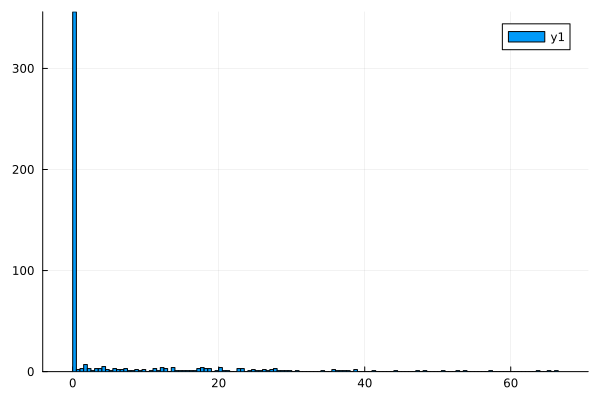

In [347]:
using Plots

histogram(buses[:, :pd])

In [149]:
function initialize_model(gens, lines, buses)
    """
    Function to solve DC OPF problem 
    Inputs:
        gens -- dataframe with generator info and costs
        lines -- dataframe with transmission lines info
        buses -- dataframe with bus types and loads
    """
    # Sets
    G = 1:nrow(gens)       # G: Set of all generators
    N = 1:nrow(buses)      # N: Set of all network nodes
    L = 1:nrow(lines)      # L: Set of all lines/branches
    fbus = lines[!,:f_bus] # All from buses
    tbus = lines[!,:t_bus] # All to buses    
    demand = buses[!,:pd]  # Demand at bus all buses

    # Parameters
    baseMVA = 100      # The base MVA is 100 MVA
    θlim = π*(60/180)  # Absolute max angle limit in rad
    slack_bus = 416    # Set slack bus to one with many CTs
    shed_cost = 1000   # Cost of load sheding

    # Toy parameters for a limited investment in solar at each bus
    budget = 0
    solar_cost = 0.1475
    
    # Model
    DCOPF = Model(()->Gurobi.Optimizer())
    set_optimizer_attribute(DCOPF, "NumericFocus", 2)
    
    # Decision variables   
    @variables(DCOPF, begin
        GEN[G]          # Generation of each generator 
        SHED[N] ≥ 0     # Load sheading at bus N
        THETA[N]        # Voltage phase angle of bus
        FLOW[N,N]       # Flows between all pairs of nodes
        
    end)

    @constraint(DCOPF, cShed[i ∈ N], SHED[i] ≤ demand[i])
    
    # Objective function (Note: Using just the linear part of quadratic cost)
    @objective(DCOPF, Min, 
        sum(gens[g,:c1] * GEN[g] for g ∈ G) + sum(shed_cost*SHED[i] for i ∈ N))
    
    # Supply demand balances: sum(generation) + shedding - demand - 0.5*sum(losses) = sum(flows)
    @constraint(DCOPF, cBalance[i ∈ N], 
        sum(GEN[g] for g ∈ G[gens.bus .== i])
        - demand[i] + SHED[i]
         == sum(FLOW[i,j] for j ∈ tbus[fbus .== i]))
    
    # Max and min generation constraints
    @constraint(DCOPF, cMaxGen[g ∈ G], GEN[g] ≤ gens[g,:pmax])
    @constraint(DCOPF, cMinGen[g ∈ G], GEN[g] ≥ gens[g,:pmin])
    
    # Max line flow constraints
    @constraint(DCOPF, cLineLimits[l ∈ L], 
        FLOW[lines[l,:f_bus], lines[l,:t_bus]] ≤ lines[l,:rate_a]*baseMVA) 

    # Create slack bus with theta=0
    fix(THETA[slack_bus], 0)
    
    # Angle limits 
    @constraint(DCOPF, cAngleLimitsMax[l ∈ L], 
        (THETA[fbus[l]] - THETA[tbus[l]]) ≤  θlim)
    @constraint(DCOPF, cAngleLimitsMin[l ∈ L], 
        (THETA[fbus[l]] - THETA[tbus[l]]) ≥ -θlim)
                    
    # Flow constraints on each branch
    @constraint(DCOPF, cLineFlows[l ∈ L],
            FLOW[fbus[l], tbus[l]] ==
            baseMVA*lines[l,:sus]*(THETA[fbus[l]] - THETA[tbus[l]]))
    
    return DCOPF
end

initialize_model (generic function with 1 method)

In [155]:
maximum(buses[:, :pd])

81.3956

In [135]:
gens

Row,id,bus,startup,shutdown,n,c2,c1,c0,fueltype,pg,pmax,pmin,qg,qmax,qmin
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,String,Float64,Float64,Int64,Int64,Float64,Float64
1,320,7,0.0,0.0,3.0,0.0787244,14.8788,34.6468,Conventional Hydroelectric,0.233335,0.7,0,0,18.7771,-14.6707
2,321,7,0.0,0.0,3.0,0.0787244,14.8788,34.6468,Conventional Hydroelectric,0.233335,0.7,0,0,18.7771,-14.6707
3,445,18,0.0,0.0,3.0,0.0947039,22.4096,554.685,Other Waste Biomass,0.0,0.8,0,0,13.9,-9.5
4,446,18,0.0,0.0,3.0,0.0947039,22.4096,554.685,Other Waste Biomass,0.0,0.8,0,0,13.9,-9.5
5,447,18,0.0,0.0,3.0,0.0947039,22.4096,554.685,Other Waste Biomass,0.0,0.8,0,0,13.9,-9.5
6,448,18,0.0,0.0,3.0,0.0947039,22.4096,554.685,Other Waste Biomass,0.0,0.8,0,0,13.9,-9.5
7,458,112,0.0,0.0,3.0,0.0511408,13.5022,315.964,Natural Gas Fired Combustion Turbine,4.50003,4.5,0,0,24.5645,-14.3219
8,466,437,0.0,0.0,3.0,0.0511408,13.5022,315.964,Natural Gas Fired Combustion Turbine,4.80004,4.8,0,0,24.5645,-14.3219
9,467,437,0.0,0.0,3.0,0.298333,25.05,57.6,Petroleum Liquids,0.0,1.5,0,0,30.8333,-20.8


In [287]:
sum(lines[:, :x] .< 1e-4) # 0.001

54

In [ ]:
read